In [1]:
# univariate lstm example
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [3]:
pax_df = pd.read_excel("Yearly_passengers_lookup_table_crosstab.xlsx")

In [4]:
pax_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 6 columns):
Unnamed: 0              29 non-null int64
Enplaning Passengers    29 non-null int64
Deplaning Passengers    29 non-null int64
Domestic Passengers     29 non-null int64
Int'l Passengers        29 non-null int64
Total Passengers        29 non-null int64
dtypes: int64(6)
memory usage: 1.4 KB


In [5]:
pax_df.head()

,Unnamed: 0,Enplaning Passengers,Deplaning Passengers,Domestic Passengers,Int'l Passengers,Total Passengers
0,1990,8225920,8014389,14399529,1840780,16240309
1,1991,8294093,8019196,14759181,1554108,16313289
2,1992,8978740,8983477,16462515,1499702,17962217
3,1993,9384565,9415959,17393527,1406997,18800524
4,1994,10471150,10501669,19482971,1489848,20972819


In [6]:
# define input sequence
raw_seq = pax_df['Enplaning Passengers'].tolist()
print(raw_seq)

[8225920, 8294093, 8978740, 9384565, 10471150, 11390521, 12132987, 12341391, 12867987, 13802136, 14173752, 13505980, 13362314, 13355667, 14364242, 14632137, 14990647, 15661235, 16084939, 15610198, 15773348, 16397488, 16597324, 17376316, 18716778, 21108756, 22796118, 23415582, 24894338]


In [7]:
len(raw_seq)

29

In [8]:
# choose a number of time steps
n_steps = 3

In [9]:
# split into samples
X, y = split_sequence(raw_seq, n_steps)

In [10]:
print(X)
print(y)

[[ 8225920  8294093  8978740]
 [ 8294093  8978740  9384565]
 [ 8978740  9384565 10471150]
 [ 9384565 10471150 11390521]
 [10471150 11390521 12132987]
 [11390521 12132987 12341391]
 [12132987 12341391 12867987]
 [12341391 12867987 13802136]
 [12867987 13802136 14173752]
 [13802136 14173752 13505980]
 [14173752 13505980 13362314]
 [13505980 13362314 13355667]
 [13362314 13355667 14364242]
 [13355667 14364242 14632137]
 [14364242 14632137 14990647]
 [14632137 14990647 15661235]
 [14990647 15661235 16084939]
 [15661235 16084939 15610198]
 [16084939 15610198 15773348]
 [15610198 15773348 16397488]
 [15773348 16397488 16597324]
 [16397488 16597324 17376316]
 [16597324 17376316 18716778]
 [17376316 18716778 21108756]
 [18716778 21108756 22796118]
 [21108756 22796118 23415582]]
[ 9384565 10471150 11390521 12132987 12341391 12867987 13802136 14173752
 13505980 13362314 13355667 14364242 14632137 14990647 15661235 16084939
 15610198 15773348 16397488 16597324 17376316 18716778 21108756 22796118


In [11]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [12]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

Instructions for updating:
Colocations handled automatically by placer.


In [13]:
# fit model
model.fit(X, y, epochs=500, verbose=0)

Instructions for updating:
Use tf.cast instead.


In [14]:
# demonstrate prediction
x_input = array(raw_seq[-n_steps:])
x_input = x_input.reshape((1, n_steps, n_features))

In [15]:
x_input

array([[[22796118],
        [23415582],
        [24894338]]])

In [16]:
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[25695712.]]


In [17]:
x_input.shape

(1, 3, 1)

In [18]:
np.delete(x_input, 0, 1)

array([[[23415582],
        [24894338]]])

In [19]:
np.append(x_input, [yhat], 1)

array([[[22796118.],
        [23415582.],
        [24894338.],
        [25695712.]]])

In [20]:
# Forecast for these many years in future
forecast_horizon = 20
forecast_df = pd.DataFrame(index = range(2019, 2040), columns = ['enplaning'])

In [21]:
forecast_df.loc[2019,'enplaning'] = yhat[0][0]

In [22]:
forecast_df

,enplaning
2019,2.56957e+07
2020,NaN
2021,NaN
2022,NaN
2023,NaN
2024,NaN
2025,NaN
2026,NaN
2027,NaN
2028,NaN


In [23]:
# Use a recursive strategu for forecasting mutiple steps 
for i in range(forecast_horizon):
    x_input = np.delete(x_input, 0, 1)
    x_input = np.append(x_input, [yhat], 1)
    yhat = model.predict(x_input, verbose=0)
    print(yhat)
    forecast_df.loc[2019+i+1, 'enplaning'] = yhat[0][0]

[[26753884.]]
[[27954070.]]
[[29060964.]]
[[30278844.]]
[[31551548.]]
[[32852270.]]
[[34222790.]]
[[35648052.]]
[[37128836.]]
[[38674588.]]
[[40283624.]]
[[41959156.]]
[[43705056.]]
[[45523290.]]
[[47417148.]]
[[49389916.]]
[[51444680.]]
[[53584944.]]
[[55814264.]]
[[58136316.]]


In [24]:
forecast_df

,enplaning
2019,25695712
2020,26753884
2021,27954070
2022,29060964
2023,30278844
2024,31551548
2025,32852270
2026,34222792
2027,35648052
2028,37128836


In [25]:
lf_forecast = { 
    2019: 22407600, 
    2024: 25913700,
    2029: 29460800, 
    2034: 32823600
    }

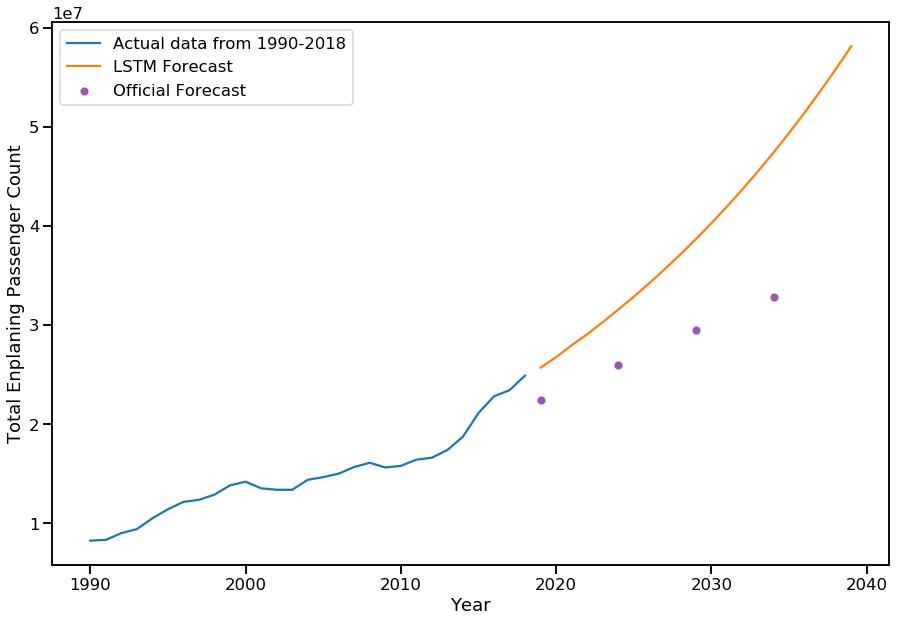

In [37]:
sns.set_context('talk')
fig0, ax0 = plt.subplots(1, 1, figsize=(15,10))
sns.lineplot(x = pax_df['Unnamed: 0'], y = pax_df['Enplaning Passengers'].tolist(), ax=ax0)
sns.lineplot(x = forecast_df.index, y = forecast_df['enplaning'].tolist(), ax=ax0)
sns.scatterplot(x = list(lf_forecast.keys()), y = list(lf_forecast.values()), ax=ax0, legend="full", color="#9b59b6")
ax0.set(xlabel="Year", ylabel="Total Enplaning Passenger Count")
ax0.legend(labels=["Actual data from 1990-2018", "LSTM Forecast", "Official Forecast"])